## 1 - Importe as bibliotecas necessárias:

In [428]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import gensim
import seaborn as sns
import matplotlib.pylab as plt


## 2 - Carregue os dados em um DataFrame do pandas:

In [429]:
df = pd.read_excel('imoveis_uberlandia.xlsx', dtype={'preco': int})

df = df.replace('_', ' ').replace(' -- ', -1)
df = df.drop(df.index[:20])

print(df.shape)
display(df)

(46204, 9)


,titulo,tipo_imovel,metragem,link,quartos,vagas,banheiros,preco,bairro
20,"Lote/Terreno com Quarto para Aluguel, 3900m²",apartamento,3900,https://www.vivareal.com.br/imovel/casa-3-quar...,1,-1,1,60000,santa_monica
21,"Apartamento com 4 Quartos para Aluguel, 210m²",apartamento,210,https://www.vivareal.com.br/imovel/casa-3-quar...,4,2,1,5500,santa_monica
22,"Ponto comercial/Loja/Box para Aluguel, 35...",apartamento,350,https://www.vivareal.com.br/imovel/casa-3-quar...,-1,-1,2,30000,santa_monica
23,"Apartamento com 2 Quartos para Aluguel, 80m²",apartamento,80,https://www.vivareal.com.br/imovel/casa-3-quar...,2,2,3,1900,santa_monica
24,"Apartamento com 2 Quartos para Aluguel, 44m²",apartamento,44,https://www.vivareal.com.br/imovel/casa-3-quar...,2,1,1,1300,santa_monica
...,...,...,...,...,...,...,...,...,...
46219,"Apartamento com 2 Quartos para Aluguel, 58m²",apartamento,58,https://www.vivareal.com.br/imovel/apartamento...,2,1,2,1550,loteamento_portal_do_vale_ii
46220,"Casa com 3 Quartos para Aluguel, 220m²",apartamento,220,https://www.vivareal.com.br/imovel/apartamento...,3,2,2,3000,loteamento_portal_do_vale_ii
46221,"Ponto comercial/Loja/Box para Aluguel, 88...",apartamento,88,https://www.vivareal.com.br/imovel/apartamento...,-1,24,1,2200,loteamento_portal_do_vale_ii
46222,"Apartamento com 2 Quartos para Aluguel, 50m²",apartamento,50,https://www.vivareal.com.br/imovel/apartamento...,2,1,1,750,loteamento_portal_do_vale_ii


## 2.1 - Tratamento de dados

In [430]:
df = df.drop(['link', 'tipo_imovel'], axis=1)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46204 entries, 20 to 46223
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   titulo     46204 non-null  object
 1   metragem   46204 non-null  object
 2   quartos    46204 non-null  object
 3   vagas      46204 non-null  object
 4   banheiros  46204 non-null  object
 5   preco      46204 non-null  int32 
 6   bairro     46204 non-null  object
dtypes: int32(1), object(6)
memory usage: 2.3+ MB
None


# 3 - aplicar a técnica de embedding nas colunas de descrição e bairro

    1) Crie um corpus de texto com as informações das colunas de descrição e bairro. O corpus é uma lista de listas, em que cada sublista é uma lista de tokens representando cada documento (no caso, cada descrição e bairro). Você pode usar a função "tokenize" da biblioteca "gensim" para dividir as strings em tokens.

In [431]:
corpus_descricao = [descricao for descricao in df['titulo']]
corpus_bairro  = [bairro for bairro in df['bairro']]



    2) Crie um modelo de embedding Word2Vec usando o corpus de texto. O modelo aprende a representação vetorial dos tokens no espaço vetorial de alta dimensionalidade.
    
O modelo Word2Vec é um modelo de aprendizado de máquina que é usado para criar representações vetoriais de palavras ou tokens. Ele é treinado usando um corpus de texto (uma coleção de documentos), que é usado para aprender a relação entre as palavras ou tokens. O modelo usa duas abordagens diferentes para treinar os vetores de palavras: o Skip-gram e o CBOW (Continuous Bag of Words).

No Skip-gram, o modelo prevê a probabilidade de ocorrência de uma palavra dada sua vizinhança. Ou seja, dada uma palavra de entrada, o modelo tenta prever as palavras que estão próximas a ela. O modelo aprende os vetores de palavra de tal maneira que palavras que ocorrem com frequência juntas no corpus terão vetores de palavra semelhantes.

No CBOW, o modelo tenta prever a palavra de entrada a partir de um conjunto de palavras vizinhas. Em outras palavras, o modelo recebe várias palavras de entrada e tenta prever a palavra de saída. O modelo aprende os vetores de palavra de tal maneira que as palavras que têm contextos semelhantes terão vetores de palavra semelhantes.

Uma vez que o modelo é treinado, os vetores de palavra podem ser usados ​​como uma representação densa de cada token (palavra ou outro tipo de unidade). Essa representação é de alta dimensionalidade, mas pode ser reduzida usando técnicas como PCA ou t-SNE para visualização.

No caso da aplicação em um modelo de previsão de preço de imóveis, o Word2Vec pode ser usado para criar representações vetoriais dos tokens da coluna de descrição e da coluna de bairro. Essas representações podem ser usadas como entradas em uma rede neural, permitindo que o modelo aprenda padrões complexos nos dados de entrada.

In [432]:
model_descricao = gensim.models.Word2Vec(corpus_descricao, min_count=1)
model_bairro = gensim.models.Word2Vec(corpus_bairro, min_count=1)

    3) Para cada descrição e bairro, calcule a representação vetorial média dos tokens. Isso pode ser feito somando os vetores de cada token e dividindo pelo número de tokens.
    
Este ponto refere-se ao cálculo da representação vetorial média dos tokens das descrições e bairros. Para cada descrição e bairro, é criado um vetor de representação vetorial, que é a soma dos vetores correspondentes de cada token encontrado na descrição/bairro. Depois, esse vetor é dividido pelo número total de tokens para obter a representação média vetorial.

O código abaixo deve fazer exatamente isso: para cada descrição e bairro, é criada uma lista vazia. Em seguida, é feita uma iteração em cada token da descrição/bairro. Se o token estiver no modelo Word2Vec criado anteriormente, seu vetor correspondente é adicionado ao vetor de representação vetorial da descrição/bairro. No final, o vetor de representação vetorial é dividido pelo número total de tokens para obter a representação média vetorial. Esse processo é repetido para todas as descrições e bairros, e os vetores resultantes são armazenados nas listas X_descricao e X_bairro.

In [433]:
X_descricao = []

for descricao in corpus_descricao:
    # cria uma matriz de zeros com 100 elemento
    desc_emb = np.zeros(100)
    
    for i, token in enumerate(descricao):
        if token in model_descricao.wv.key_to_index:
            # adiciona o vetor correspondente ao token à matriz
            desc_emb += model_descricao.wv[token]
            
            # adiciona a matriz de embeddings da descrição à lista de features
    X_descricao.append(desc_emb)

for i, x in enumerate(X_descricao):
    if i < 100:
        #print(x)
        pass
X_bairro = []

for bairro in corpus_bairro:
    bairro_emb = np.zeros(100)
    
    for token in bairro:
        if token in model_bairro.wv.key_to_index:
            bairro_emb += model_bairro.wv[token]
    X_bairro.append(bairro_emb)



    4) Junte as representações vetoriais das colunas de descrição e bairro em um único DataFrame e utilize-o como entrada do modelo de rede neural.

In [434]:
X_descricao = np.array(X_descricao)
X_bairro = np.array(X_bairro)

df['titulo'] = X_descricao
df['bairro'] = X_bairro

## 3 - Separe as variáveis independentes (características) das variáveis dependentes (preço do aluguel):

In [435]:
x = df.drop('preco', axis=1)
y = df['preco']

df['vagas'] = df['vagas'].astype(int)
df['banheiros'] = df['banheiros'].astype(int)
df['quartos'] = df['quartos'].astype(int)
df['metragem'] = df['metragem'].astype(int)



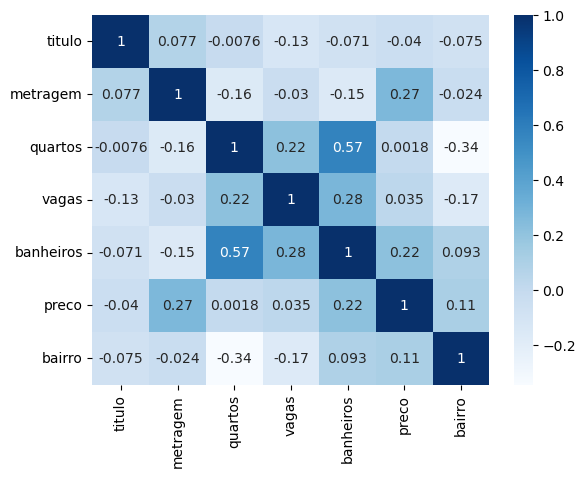

In [436]:
correlacao = df.corr()
sns.heatmap(data=correlacao, cmap='Blues', annot=True)
plt.show()

## 5 - Divida os dados em conjuntos de treinamento e teste:

In [437]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.3)

## 6 - Defina o modelo de rede neural e ajuste-o aos dados de treinamento:

In [438]:
modelo = MLPRegressor(hidden_layer_sizes=(100,50), activation='relu', solver='adam', max_iter=500)

modelo.fit(x_treino, y_treino)


MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500)

## 7 - Avalie o desempenho do modelo nos dados de teste:

In [439]:
previsao = modelo.predict(x_teste)

print(r2_score(y_teste, previsao))

0.20592634475784177


## 8 - Use o modelo para fazer previsões:

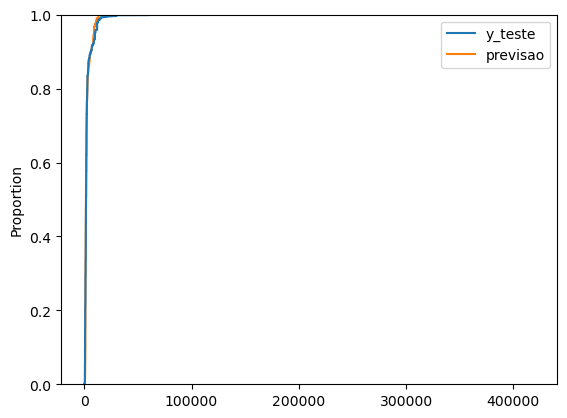

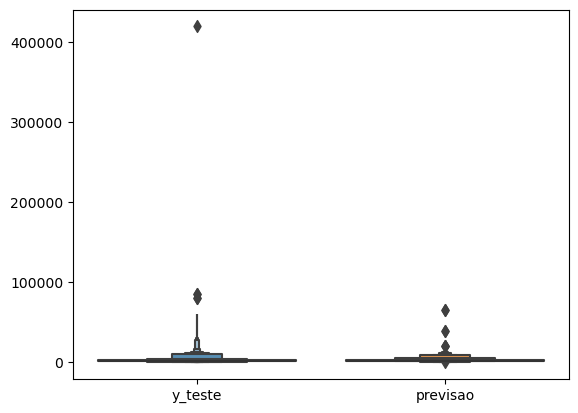

In [440]:
df_res = pd.DataFrame()

df_res['y_teste'] = y_teste
df_res['previsao'] = previsao

sns.ecdfplot(data=df_res)
plt.show()

sns.boxenplot(data=df_res)
plt.show()

In [441]:
novos_imoveis = pd.read_excel('imoveis_uberlandia.xlsx')


In [442]:
novos_imoveis = novos_imoveis.head(n=20)
novos_imoveis = novos_imoveis.drop(['tipo_imovel', 'link'], axis=1)
original = pd.read_excel('imoveis_uberlandia.xlsx').head(n=20).drop(['tipo_imovel', 'link'], axis=1)
display(novos_imoveis)

,titulo,metragem,quartos,vagas,banheiros,preco,bairro
0,"Casa com 3 Quartos para Aluguel, 161m²",161,3,2,3,2000,santa_monica
1,Apartamento com 2 Quartos à Venda/Aluguel 71...,71,2,2,2,180,santa_monica
2,"Apartamento com 3 Quartos para Aluguel, 108m²",108,3,2,2,1750,santa_monica
3,"Apartamento com 3 Quartos para Aluguel, 90m²",90,3,2,1,1980,santa_monica
4,"Apartamento com 3 Quartos para Aluguel, 107m²",107,3,2,2,2600,santa_monica
5,"Casa com 3 Quartos para Aluguel, 234m²",234,3,2,2,3000,santa_monica
6,"Apartamento com 2 Quartos para Aluguel, 57m²",57,2,1,1,1500,santa_monica
7,"Apartamento com 3 Quartos para Aluguel, 118m²",118,3,1,1,1800,santa_monica
8,"Apartamento com 3 Quartos para Aluguel, 115m²",115,3,2,1,1800,santa_monica
9,"Apartamento com 3 Quartos para Aluguel, 86m²",86,3,2,2,2700,santa_monica


In [443]:
corpus_descricao = [descricao for descricao in novos_imoveis['titulo']]
corpus_bairro  = [bairro for bairro in novos_imoveis['bairro']]
model_descricao = gensim.models.Word2Vec(corpus_descricao, min_count=1)
model_bairro = gensim.models.Word2Vec(corpus_bairro, min_count=1)

X_descricao = []

for descricao in corpus_descricao:
    # cria uma matriz de zeros com 100 elemento
    desc_emb = np.zeros(100)
    
    for i, token in enumerate(descricao):
        if token in model_descricao.wv.key_to_index:
            # adiciona o vetor correspondente ao token à matriz
            desc_emb += model_descricao.wv[token]
            
            # adiciona a matriz de embeddings da descrição à lista de features
    X_descricao.append(desc_emb)

X_bairro = []

for bairro in corpus_bairro:
    bairro_emb = np.zeros(100)
    
    for token in bairro:
        if token in model_bairro.wv.key_to_index:
            bairro_emb += model_bairro.wv[token]
    X_bairro.append(bairro_emb)

X_descricao = np.array(X_descricao)
X_bairro = np.array(X_bairro)

novos_imoveis['titulo'] = X_descricao
novos_imoveis['bairro'] = X_bairro

In [444]:
display(novos_imoveis.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   titulo     20 non-null     float64
 1   metragem   20 non-null     object 
 2   quartos    20 non-null     object 
 3   vagas      20 non-null     object 
 4   banheiros  20 non-null     object 
 5   preco      20 non-null     int64  
 6   bairro     20 non-null     float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.2+ KB


None

In [445]:
novos_imoveis = novos_imoveis.replace('_', ' ').replace(' -- ', -1)
novos_imoveis['vagas'] = novos_imoveis['vagas'].astype(int)
novos_imoveis['banheiros'] = novos_imoveis['banheiros'].astype(int)
novos_imoveis['quartos'] = novos_imoveis['quartos'].astype(int)
novos_imoveis['metragem'] =novos_imoveis['metragem'].astype(int)

In [446]:
display(novos_imoveis.info())
display(novos_imoveis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   titulo     20 non-null     float64
 1   metragem   20 non-null     int32  
 2   quartos    20 non-null     int32  
 3   vagas      20 non-null     int32  
 4   banheiros  20 non-null     int32  
 5   preco      20 non-null     int64  
 6   bairro     20 non-null     float64
dtypes: float64(2), int32(4), int64(1)
memory usage: 928.0 bytes


None

,titulo,metragem,quartos,vagas,banheiros,preco,bairro
0,-0.319246,161,3,2,3,2000,-0.038172
1,-0.327151,71,2,2,2,180,-0.038172
2,-0.330549,108,3,2,2,1750,-0.038172
3,-0.319804,90,3,2,1,1980,-0.038172
4,-0.325140,107,3,2,2,2600,-0.038172
5,-0.332135,234,3,2,2,3000,-0.038172
6,-0.330882,57,2,1,1,1500,-0.038172
7,-0.336922,118,3,1,1,1800,-0.038172
8,-0.324882,115,3,2,1,1800,-0.038172
9,-0.334217,86,3,2,2,2700,-0.038172


In [447]:
novos_imoveis = novos_imoveis.drop('preco', axis=1)
predicao = modelo.predict(novos_imoveis)

In [448]:
novos_imoveis['preco'] = predicao

In [449]:
display(novos_imoveis)
display(original)


,titulo,metragem,quartos,vagas,banheiros,bairro,preco
0,-0.319246,161,3,2,3,-0.038172,2763.832929
1,-0.327151,71,2,2,2,-0.038172,1574.803590
2,-0.330549,108,3,2,2,-0.038172,1931.614602
3,-0.319804,90,3,2,1,-0.038172,1401.864456
4,-0.325140,107,3,2,2,-0.038172,1924.062765
5,-0.332135,234,3,2,2,-0.038172,4112.033853
6,-0.330882,57,2,1,1,-0.038172,1073.739533
7,-0.336922,118,3,1,1,-0.038172,1632.677544
8,-0.324882,115,3,2,1,-0.038172,1601.733404
9,-0.334217,86,3,2,2,-0.038172,1769.778705


,titulo,metragem,quartos,vagas,banheiros,preco,bairro
0,"Casa com 3 Quartos para Aluguel, 161m²",161,3,2,3,2000,santa_monica
1,Apartamento com 2 Quartos à Venda/Aluguel 71...,71,2,2,2,180,santa_monica
2,"Apartamento com 3 Quartos para Aluguel, 108m²",108,3,2,2,1750,santa_monica
3,"Apartamento com 3 Quartos para Aluguel, 90m²",90,3,2,1,1980,santa_monica
4,"Apartamento com 3 Quartos para Aluguel, 107m²",107,3,2,2,2600,santa_monica
5,"Casa com 3 Quartos para Aluguel, 234m²",234,3,2,2,3000,santa_monica
6,"Apartamento com 2 Quartos para Aluguel, 57m²",57,2,1,1,1500,santa_monica
7,"Apartamento com 3 Quartos para Aluguel, 118m²",118,3,1,1,1800,santa_monica
8,"Apartamento com 3 Quartos para Aluguel, 115m²",115,3,2,1,1800,santa_monica
9,"Apartamento com 3 Quartos para Aluguel, 86m²",86,3,2,2,2700,santa_monica


<AxesSubplot:>

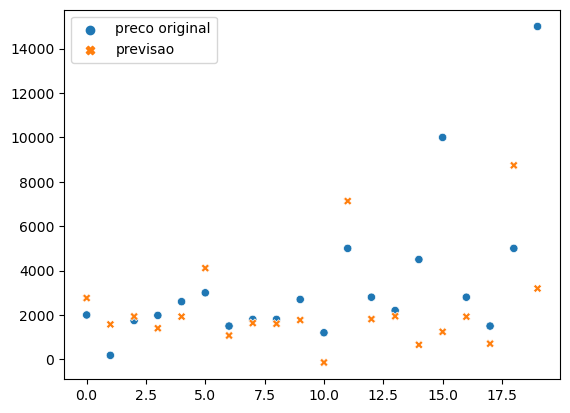

In [450]:
visualiza = pd.DataFrame()
visualiza['preco original'] = original['preco']
visualiza['previsao'] = novos_imoveis['preco']

sns.scatterplot(data=visualiza)